Mô tả bài toán:

- Input: Ảnh giám sát
- Output: 2 đầu ra

Ảnh:
  + Đóng khung vùng cần với tên class trong task: traffic light
  + Nếu traffic light về stop hoặc leftstop thì Xác định vùng vi phạm => Object Detection
  + vạch dừng draw

OCR

chỉnh:
- Điều kiện Vùng vi phạm
- Nếu biển số trùng thì loại bỏ bớt
-





# **Library**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import load_model
import cv2
import time
from collections import deque
import numpy as np
import matplotlib.pyplot as plt


import time
from concurrent.futures import ThreadPoolExecutor

#**Functions**

## classific the traffic light



In [ ]:
# Hàm tải mô hình phát hiện đối tượng
def load_graph():
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

# def select_boxes_for_traffic_light(boxes, classes, scores, score_threshold=0.5, target_class=10):
#     mask = (np.squeeze(classes) == target_class) & (np.squeeze(scores) > score_threshold)
#     return np.squeeze(boxes)[mask]

def select_boxes_for_traffic_light(boxes, classes, scores, score_threshold=0.2, target_class=10):
    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)
    sel_id = np.logical_and(sq_classes == target_class, sq_scores > score_threshold)
    return sq_boxes[sel_id]

def select_boxes_for_vehicle(boxes, classes, scores, score_threshold=0.2, target_classes=None):
    if target_classes is None:
        target_classes = [4, 6, 8]  # Chỉnh sửa hoặc xác nhận các ID này
    sq_scores = np.squeeze(scores)
    sq_classes = np.squeeze(classes)
    sq_boxes = np.squeeze(boxes)
    sel_idx = [(cls in target_classes) and (sc > score_threshold) for cls, sc in zip(sq_classes, sq_scores)]
    return sq_boxes[sel_idx]

# Lớp phân loại đèn giao thông
class TLClassifier(object):
    def __init__(self):
        self.detection_graph = load_graph()
        self.extract_graph_components()
        self.sess = tf.compat.v1.Session(graph=self.detection_graph)

    def extract_graph_components(self):
        self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
        self.detection_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
        self.detection_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
        self.detection_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
        self.num_detections = self.detection_graph.get_tensor_by_name('num_detections:0')

    def detect_multi_object_for_traffic_light(self, image_np, score_threshold=0.2):
        image_np_expanded = np.expand_dims(image_np, axis=0)
        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})
        sel_boxes = select_boxes_for_traffic_light(boxes=boxes, classes=classes, scores=scores, score_threshold=score_threshold, target_class=10)
        return sel_boxes

    def detect_multi_object_for_vehicle(self, image_np, score_threshold=0.2):
        image_np_expanded = np.expand_dims(image_np, axis=0)
        (boxes, scores, classes, num) = self.sess.run(
            [self.detection_boxes, self.detection_scores, self.detection_classes, self.num_detections],
            feed_dict={self.image_tensor: image_np_expanded})
        sel_boxes = select_boxes_for_vehicle(boxes=boxes, classes=classes, scores=scores, score_threshold=score_threshold)
        return sel_boxes

# Hàm cắt hình ảnh vùng quan tâm (ROI)
def crop_roi_image(image_np, sel_box):
    im_height, im_width, _ = image_np.shape
    left, top, right, bottom = (sel_box[1] * im_width, sel_box[0] * im_height, sel_box[3] * im_width, sel_box[2] * im_height)
    return image_np[int(top):int(bottom), int(left):int(right), :]

In [ ]:
def classif_inceptionv3(image, model, class_names, box):
    '''
    Hàm phân loại traffic light
    '''

    im1 = Image.fromarray(image).resize((224, 224), Image.LANCZOS)
    input_arr = np.expand_dims(tf.keras.preprocessing.image.img_to_array(im1), axis=0)
    predictions = model.predict(input_arr)
    predicted_class_name = list(class_names.keys())[np.argmax(predictions)]

    return predicted_class_name

In [ ]:
def traffic_light(image, class_names, model, frame):
    '''
    Hiển thị tên class và Vẽ khung chứa traffic light (tương ứng cho màu của light)
    '''
    # Mapping class names to colors
    color_mapping = {
        'stop': (0, 0, 255),    # Red
        'go': (0, 255, 0),  # Green
        'warning': (0, 255, 255) # Yellow
    }

    tlc = TLClassifier()
    boxes = tlc.detect_multi_object_for_traffic_light(image, score_threshold=0.2)

    # Có bounding box --> classification [hiển thị]
    if len(boxes) > 0:
        # Hiển thị tên class của bounding box này
        cropped_image = crop_roi_image(image, boxes[0])
        predicted_class_name = classif_inceptionv3(cropped_image, model, class_names, boxes[0])  # Sử dụng model

        box = boxes[0]
        left, top, right, bottom = int(box[1] * frame.shape[1]), int(box[0] * frame.shape[0]), int(box[3] * frame.shape[1]), int(box[2] * frame.shape[0])

        # Get the color based on the predicted class name
        color = color_mapping.get(predicted_class_name, (255, 255, 255))  # Default to white if class not found

        # Draw the bounding box and class name text
        cv2.rectangle(frame, (left, top), (right, bottom), color, 2)
        cv2.putText(frame, predicted_class_name, (left, top - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        return predicted_class_name, frame

    # Trường hợp không có bounding box nào được phát hiện
    return "No traffic light detected", frame

## Line Detection And Area Violation

- B1: Line Detection (Phát hiện và vẽ đường thẳng dừng)
- B2: Vẽ vùng nhận diện phương tiện vi phạm (phát triển dựa trên line detection)


B1: Phát hiện và vẽ đường thẳng dừng - Với task này hiển thị đường kẻ theo pp bạn code

In [ ]:
# Định nghĩa lớp LineDetector
class LineDetector:
    def __init__(self, num_frames_avg=10):
        self.y_start_queue = deque(maxlen=num_frames_avg)
        self.y_end_queue = deque(maxlen=num_frames_avg)

    def detect_white_line(self, frame, color, slope1=0, intercept1=2100, slope2=0, intercept2=1400, slope3=-1, intercept3=-2400):
        # Code to detect white line
        def get_color_code(color_name):
            color_codes = {
                'red': (0, 0, 255),
                'green': (0, 255, 0),
                'yellow': (0, 255, 255)
            }
            return color_codes.get(color_name.lower())

        frame_org = frame.copy()
        height, width, _ = frame.shape

        def line1(x): return slope1 * x + intercept1
        def line2(x): return slope2 * x + intercept2
        def line3(x): return slope3 * x + intercept3

        mask1 = frame.copy()
        for x in range(width):
            y_line = line1(x)
            mask1[int(y_line):, x] = 0

        mask2 = mask1.copy()
        for x in range(width):
            y_line = line2(x)
            mask2[:int(y_line), x] = 0

        mask3 = mask2.copy()
        for y in range(height):
            x_line = line3(y)
            mask3[y, :int(x_line)] = 0

        gray = cv2.cvtColor(mask3, cv2.COLOR_BGR2GRAY)
        blurred_gray = cv2.GaussianBlur(gray, (7, 7), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        gray_clahe = clahe.apply(blurred_gray)
        edges = cv2.Canny(gray, 0, 0)
        dilated_edges = cv2.dilate(edges, None, iterations=1)
        edges = cv2.erode(dilated_edges, None, iterations=1)

        rho = 1
        theta = np.pi / 180
        threshold = 1000
        minLineLength = 100
        maxLineGap = 5

        x1, y1 = width * -0.1, height * -0.8
        x2, y2 = width * -0.9, height * -0.8
        x3, y3 = width * -0.9, height
        x4, y4 = width * -0.1, height
        roi_vertices = [(x1, y1), (x2, y2), (x3, y3), (x4, y4)]

        lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), minLineLength=minLineLength, maxLineGap=maxLineGap)

        mask = np.zeros_like(edges)
        cv2.fillPoly(mask, np.array([roi_vertices], dtype=np.int32), 255)
        masked_edges = cv2.bitwise_and(edges, mask)

        x_start = 0
        x_end = 2600

        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                slope = (y2 - y1) / (x2 - x1 + np.finfo(float).eps)
                intercept = y1 - slope * x1
                y_start = int(slope * x_start + intercept)
                y_end = int(slope * x_end + intercept)
                self.y_start_queue.append(y_start)
                self.y_end_queue.append(y_end)

        avg_y_start = int(sum(self.y_start_queue) / len(self.y_start_queue)) if self.y_start_queue else 0
        avg_y_end = int(sum(self.y_end_queue) / len(self.y_end_queue)) if self.y_end_queue else 0

        line_start_ratio=0.375
        x_start_adj = x_start + int(line_start_ratio * (x_end - x_start))
        avg_y_start_adj = avg_y_start + int(line_start_ratio * (avg_y_end - avg_y_start))
        mask = np.zeros_like(frame)
        # mask: Ảnh đen nơi đường kẻ sẽ được vẽ.
        # (x_start_adj, avg_y_start_adj): Tọa độ điểm bắt đầu của đường kẻ.
        # (x_end, avg_y_end): Tọa độ điểm kết thúc của đường kẻ.
        # (255, 255, 255): Màu của đường kẻ (màu trắng).
        # 4: Độ dày của đường kẻ.
        cv2.line(mask, (x_start_adj, avg_y_start_adj), (x_end, avg_y_end), (255, 255, 255), 4)

        color_code = get_color_code(color)
        if color_code == (0, 255, 0):
            channel_indices = [1]
        elif color_code == (0, 0, 255):
            channel_indices = [2]
        elif color_code == (0, 255, 255):
            channel_indices = [1, 2]
        else:
            raise ValueError('Unsupported color')

        for channel_index in channel_indices:
            frame[mask[:,:,channel_index] == 255, channel_index] = 255

        slope_avg = (avg_y_end - avg_y_start) / (x_end - x_start + np.finfo(float).eps)
        intercept_avg = avg_y_start - slope_avg * x_start
        mask_line = np.copy(frame_org)
        for x in range(width):
            y_line = slope_avg * x + intercept_avg - 1
            mask_line[:int(y_line), x] = 0

        return frame, mask_line, (x_start_adj, avg_y_start_adj, x_end, avg_y_end)

B2: Vẽ vùng nhận diện phương tiện vi phạm (phát triển dựa trên line detection)

In [ ]:
def draw_violation_area(frame, x_start_adj, avg_y_start_adj, x_end, avg_y_end):
    """
    Draws a rectangle on the frame indicating the area for detecting vehicle violations based on the provided line.
    Args:
        frame: The video frame on which the rectangle will be drawn.
        x_start_adj: The x-coordinate of the adjusted start point.
        avg_y_start_adj: The y-coordinate of the adjusted start point.
        x_end: The x-coordinate of the end point.
        avg_y_end: The y-coordinate of the end point.
    Returns:
        The frame with the rectangle and text drawn on it.
    """
    # Tính toán các điểm để vẽ hình chữ nhật
    height, width, _ = frame.shape

    # ==================ĐÂY================================= begin
    rect_x1, rect_y1 = x_start_adj, avg_y_start_adj # x_min,
    rect_x2, rect_y2 = x_end, avg_y_end
    # # Chỉnh sửa chiều cao của hình chữ nhật, y nhỏ thì cao
    percentage_height = 0.2
    rect_y1 = min(rect_y1 - int(height * percentage_height), 1000)
    # ==================ĐÂY================================= end

    # Cách 1: điều chỉnh về tập giá trị xmin, ymin, xmax, ymax = 1000, 1000, 2500, 1800
    # rect_x1 = x_start_adj + 25
    # rect_x2 = x_end - 100
    # rect_y1 = rect_x1
    # rect_y2 = avg_y_end - 16

    # Cách 2: cài đặt dưới nền tập giá trị x1= 1000, y1= 1000, x2= 2500, y2= 1800 luôn, nhưng draw là theo line detector
    # Cách 1 cũng được nhưng khi mn nhìn thấy vùng vi phạm nó ko khớp với line detector thì sẽ dễ bị hỏi nên sẽ làm cách 2.
    # Code là vậy nhưng khi viết báo cáo ghi là phát triển từ line detector,
    # phát triển như thế nào thì xem đoạn code ====ĐÂY=== để biết thêm thông tin (nếu cần)
    # -- hoặc cũng có thể chế dựa trên cơ sở các tài liệu tham khảo khoa học để bài viết chất lượng hơn


    # Vẽ hình chữ nhật
    cv2.rectangle(frame, (rect_x1, rect_y1), (rect_x2, rect_y2), (0, 0, 255), 2)
    cv2.putText(frame, 'Vung nhan dien phuong tien vi pham', (rect_x1, rect_y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    # Cách 2 nè :>
    rect_x1, rect_y1, rect_x2, rect_y2 = 1000, 1000, 2500, 1800

    # return frame_draw, x_min, y_min, x_max, y_max
    return frame, rect_x1, rect_y1, rect_x2, rect_y2

## Object detection

Cắt vùng nhận diện phương tiện vi phạm và detect => lưu các phương tiện vi phạm mà được detect từ model ssd mobile v2 với ngưỡng 0.5 - có nhiều object detection thì lưu nhiều file

In [ ]:
def crop_image(image, xmin, ymin, xmax, ymax):
  """Crops an image to the specified bounding box.
  Returns:
    The cropped image.
  """
  return image[ymin:ymax, xmin:xmax]

def detect_and_save_objects(frame, detected_objects_output_dir_frame, xmin, ymin, xmax, ymax, score_threshold=0.2):
    cropped_image = crop_image(frame, xmin, ymin, xmax, ymax)

    tlc = TLClassifier()
    boxes = tlc.detect_multi_object_for_vehicle(cropped_image, score_threshold=score_threshold)

    if len(boxes) > 0:
        for i, box in enumerate(boxes):
            cropped_img = crop_image(cropped_image, int(box[1] * cropped_image.shape[1]), int(box[0] * cropped_image.shape[0]),
                                     int(box[3] * cropped_image.shape[1]), int(box[2] * cropped_image.shape[0]))

            # Lưu hình ảnh của đối tượng vi phạm
            violation_img_path = os.path.join(detected_objects_output_dir_frame, f"detected_object_{i + 1}.jpg")
            cv2.imwrite(violation_img_path, cropped_img)
    # if len(boxes) > 0:
    #     for box in boxes:
    #         cropped_img = crop_image(cropped_image, int(box[1] * cropped_image.shape[1]), int(box[0] * cropped_image.shape[0]),
    #                                 int(box[3] * cropped_image.shape[1]), int(box[2] * cropped_image.shape[0]))
    #         plt.imshow(cropped_img)
    #         plt.axis('off')  # Tắt hiển thị trục tọa độ
    #         plt.show()
    # else:
    #     print('No traffic vehicles detected')

## Ứng dụng

Có tính time chạy cho toàn video

- B1: Khoanh vùng traffic light
- B2: Nếu traffic light thuộc đèn đỏ (stop) thì thực hiện tiếp các task còn lại (line detect, vẽ vùng vi phạm, lưu ảnh các phương tiện vi phạm), còn lại thì bỏ qua



In [ ]:
def process_frame(frame, class_names, model, detected_objects_output_dir):
    image_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # classific the traffic light
    predicted_class_name, image_with_traffic_light = traffic_light(image_np, class_names, model, frame)
    # frame = cv2.cvtColor(image_with_traffic_light, cv2.COLOR_RGB2BGR)

    # Đặt điều kiện nếu đèn đỏ (stop, stopLeft) thì thực hiện tiếp các task còn lại, không thì bỏ qua
    if predicted_class_name in ['stop']:
        # Line Detection
        line_detector = LineDetector(num_frames_avg=10)
        detected_line_image, mask_line, (x_start_adj, avg_y_start_adj, x_end, avg_y_end) = line_detector.detect_white_line(frame, 'red')
        # frame = cv2.cvtColor(detected_line_image, cv2.COLOR_RGB2BGR)

        # Draw Violation Area
        _, xmin, ymin, xmax, ymax = draw_violation_area(frame, x_start_adj, avg_y_start_adj, x_end, avg_y_end)

        # Object detection
        # Cắt vùng nhận diện phương tiện vi phạm và detect => lưu các object detect được - có nhiều object detection thì lưu nhiều file
        detect_and_save_objects(frame, detected_objects_output_dir, xmin, ymin, xmax, ymax, score_threshold=0.2)

    return frame

In [ ]:
def process_video(video_path, output_path, detected_objects_output_dir, class_names, model):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    num_frame = 0

    start_time = time.time()

    with ThreadPoolExecutor(max_workers=4) as executor:
        futures = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            num_frame += 1
            future = executor.submit(process_frame, frame, class_names, model, detected_objects_output_dir)
            futures.append(future)

        for future in futures:
            frame = future.result()
            out.write(frame)

    end_time = time.time()
    print(f"Processing time for {num_frame} frame: {end_time - start_time} seconds")

    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
def process_image(image_path, output_path, detected_objects_output_dir, class_names, model):
    frame = cv2.imread(image_path)
    if frame is None:
        raise ValueError(f"Image at path {image_path} could not be read")

    start_time = time.time()

    frame = process_frame(frame, class_names, model, detected_objects_output_dir)

    end_time = time.time()
    print(f"Processing time for image: {end_time - start_time} seconds")

    cv2.imwrite(output_path, frame)
    print(f"Processed image saved to {output_path}")

# **Main**


Sau khi quan sát kết quả, thì các vấn đề còn tồn đọng:
- phần giới hạn trên của vùng vi phạm theo quan sát còn cố định, nhưng ko phải do cài cố định mà là do đoạn code này rect_y1 = min(rect_y1 - int(height * percentage_height), 1000), ko có gì đáng ngại. Nó vừa là điểm yếu vừa là điểm mạnh lúc viết báo cáo có thể đề cập hoặc ko. Tùy vào cách đề cập lý thuyết gì như ở phần cmt trong def draw_violation_area(frame, x_start_adj, avg_y_start_adj, x_end, avg_y_end)


## prepare

In [ ]:
# !rm -rf /content/drive/MyDrive/redLight_violaton_system/humm

Models

In [ ]:
# Cấu hình mô hình
MODEL_NAME = "ssd_mobilenet_v2_coco_2018_03_29"
extraction_directory = "/content/drive/MyDrive/kltn"
PATH_TO_CKPT = os.path.join(extraction_directory, MODEL_NAME, 'frozen_inference_graph.pb')

model = load_model('/content/drive/MyDrive/kltn/model_after_train_v3/Inceptionv3_model.h5')

class_names={'go': 0, 'stop': 1, 'warning ': 2}

##Images

In [ ]:
img_detected_objects_output_dir_1 = '/content/drive/MyDrive/redLight_violaton_system/humm/images/detect_xe_may'
os.makedirs(img_detected_objects_output_dir_1, exist_ok=True)
img_detected_objects_output_dir_2 = '/content/drive/MyDrive/redLight_violaton_system/humm/images/detect_xe_ba_gac'
os.makedirs(img_detected_objects_output_dir_2, exist_ok=True)
# Mai sau thay đường dẫn này nè!!
output_path_images_1 = '/content/drive/MyDrive/redLight_violaton_system/humm/images/detect_xe_may/xe_may.jpg'
output_path_images_2 = '/content/drive/MyDrive/redLight_violaton_system/humm/images/detect_xe_ba_gac/xe_ba_gac.jpg'
xe_may = '/content/drive/MyDrive/redLight_violaton_system/test_img2/Red_light_violation_2024-03-23_9.jpg'
xe_ba_gac = '/content/drive/MyDrive/redLight_violaton_system/test img/Red_light_violation_2024-04-14_5.jpg'

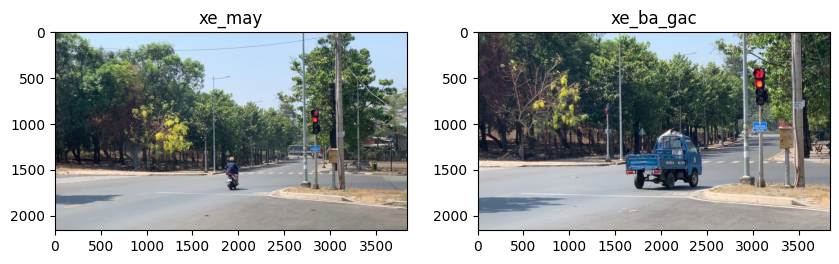

In [ ]:
images = [xe_may, xe_ba_gac]
names = ["xe_may", "xe_ba_gac"]
fig, axs = plt.subplots(1, len(images))
fig.set_figheight(10) # Kích thước
fig.set_figwidth(10) # Kích thước
for idx, image in enumerate(images):
    axs[idx].imshow(plt.imread(image))
    axs[idx].set_title(names[idx])
plt.show()

##Video

In [ ]:
vid_detected_objects_output_dir_1 = '/content/drive/MyDrive/redLight_violaton_system/humm/videos/detect_xe_may'
os.makedirs(vid_detected_objects_output_dir_1, exist_ok=True)
vid_detected_objects_output_dir_2 = '/content/drive/MyDrive/redLight_violaton_system/humm/videos/detect_xe_ba_gac'
os.makedirs(vid_detected_objects_output_dir_2, exist_ok=True)

output_path_videos_1 = '/content/drive/MyDrive/redLight_violaton_system/humm/videos/detect_xe_may/xe_may.MOV'
output_path_videos_2 = '/content/drive/MyDrive/redLight_violaton_system/humm/videos/detect_xe_ba_gac/xe_ba_gac.MOV'
video_xe_may = '/content/drive/MyDrive/redLight_violaton_system/dataset used forr testing/IMG_3759.MOV'
video_xe_ba_gac = '/content/drive/MyDrive/redLight_violaton_system/dataset used forr testing/IMG_3712 2.MOV'

## Áp dụng vào ảnh

In [ ]:
process_image(xe_may, output_path_images_1, img_detected_objects_output_dir_1, class_names, model)

1/1 [==============================] - 2s 2s/step
Processing time for image: 14.708674192428589 seconds
Processed image saved to /content/drive/MyDrive/redLight_violaton_system/humm/images/detect_xe_may/xe_may.jpg


In [ ]:
process_image(xe_ba_gac, output_path_images_2, img_detected_objects_output_dir_2, class_names, model)

1/1 [==============================] - 0s 72ms/step
Processing time for image: 12.530660629272461 seconds
Processed image saved to /content/drive/MyDrive/redLight_violaton_system/humm/images/detect_xe_ba_gac/xe_ba_gac.jpg


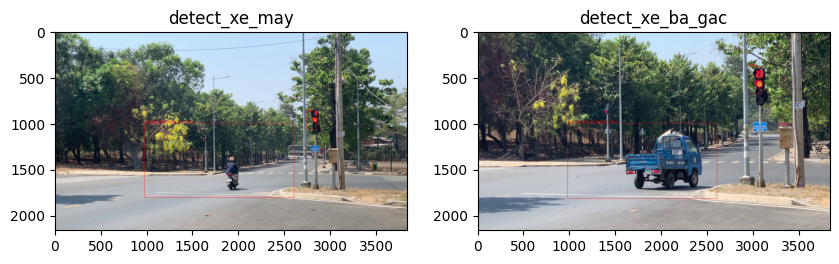

In [ ]:
images = [output_path_images_1, output_path_images_2]
names = ["detect_xe_may", "detect_xe_ba_gac"]
fig, axs = plt.subplots(1, len(images))
fig.set_figheight(10) # Kích thước
fig.set_figwidth(10) # Kích thước
for idx, image in enumerate(images):
    axs[idx].imshow(plt.imread(image))
    axs[idx].set_title(names[idx])
plt.show()

## Áp dụng vào video

In [ ]:
process_video(video_xe_may, output_path_videos_1, vid_detected_objects_output_dir_1, class_names, model)

1/1 [==============================] - 0s 88ms/step
Processing time for 765 frame: 3554.469745159149 seconds


In [ ]:
process_video(video_xe_ba_gac, output_path_videos_2, vid_detected_objects_output_dir_2, class_names, model)

1/1 [==============================] - 0s 151ms/step
Processing time for 410 frame: 1929.8521947860718 seconds


#Vehicles_lisence_detection - chưa hoàn thiện

In [ ]:
import os
from datetime import datetime

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 782.8/782.8 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/yolov5
!pip install -qr requirements.txt comet_ml

In [ ]:
script_directory = "/content/drive/MyDrive/Colab_Notebooks/yolov5"
weights_path = "runs/train/exp/weights/best.pt"
data_path = "prepare/license.yaml"

# Tạo thư mục lưu các file .txt
output_folder = '/content/Vehicles_lisence_detection/labels'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)

# Đường dẫn đến thư mục chứa các thư mục vi phạm
detected_objects_dir = "/content/detected_objects"

# Lấy ngày tháng năm hiện tại để đặt tên thư mục
current_date = datetime.now().strftime("%d-%m-%Y")
folder_name = f"{current_date}_detected"

# Chuyển đến thư mục chứa script detect.py
# os.chdir("script_directory")
%cd /content/drive/MyDrive/Colab_Notebooks/yolov5

# Duyệt qua tất cả các thư mục trong thư mục vi phạm
for root, dirs, files in os.walk(detected_objects_dir):
    for file in files:
        if file.endswith('.jpg'):
            # Tạo đường dẫn đầy đủ tới file ảnh
            image_path = os.path.join(root, file)

            # Tạo thư mục tương ứng trong thư mục đích
            relative_path = os.path.relpath(root, detected_objects_dir)
            label_folder_path = os.path.join(output_folder, relative_path)
            os.makedirs(label_folder_path, exist_ok=True)

            # Chạy script detect.py
            !python detect.py --name {folder_name} --data {data_path} --weights {weights_path} --source {image_path} --save-txt

            # Di chuyển file .txt được tạo vào thư mục tương ứng trong thư mục đích
            base_name = os.path.splitext(file)[0]
            txt_file = os.path.join(script_directory, 'runs', 'detect', folder_name, 'labels', f'{base_name}.txt')
            if os.path.exists(txt_file):
                os.rename(txt_file, os.path.join(label_folder_path, f'{base_name}.txt'))

/content/drive/MyDrive/Colab_Notebooks/yolov5
detect: weights=['runs/train/exp/weights/best.pt'], source=/content/detected_objects/frame_3/detected_object_1.jpg, data=prepare/license.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=17-06-2024_detected, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
fatal: HEAD is neither a commit nor blob
YOLOv5 🚀 2024-5-16 Python-3.10.12 torch-2.3.0+cu121 CPU

Traceback (most recent call last):
  File "/content/drive/MyDrive/Colab_Notebooks/yolov5/detect.py", line 312, in <module>
    main(opt)
  File "/content/drive/MyDrive/Colab_Notebooks/yolov5/detect.py", line 307, in main
    run(**vars(opt))
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextl

In [ ]:
Image(label_folder_path+base_name+'.jpg')

## OCR - chưa chỉnh

In [ ]:
!pip install pytesseract
!apt-get install tesseract-ocr
!apt-get install libtesseract-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,772 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121918 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
def read_txt(filepath):
    f = open(filepath, 'r')
    lines = f.readlines()
    # read objects from each line of .txt
    objects = []
    for line in lines:
        line=line.rstrip()
        obj = [float(i) for i in line.split(' ')]
        objects.append(obj)
    return objects

0.305172 0.692913 0.0977011 0.107087



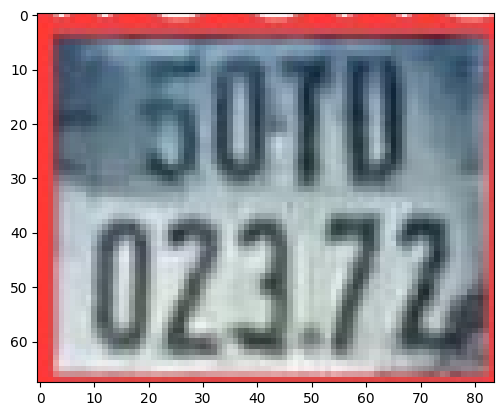

In [ ]:
from PIL import Image
img = Image.open(DETECT_PATH+IMG_NAME+'.jpg')
#Lấy kích thước ảnh
width, height = img.size

from IPython.display import Image
import pytesseract
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(DETECT_PATH+IMG_NAME+'.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

lics = read_txt(DETECT_PATH +'labels/'+IMG_NAME+'.txt')

for lic in lics:
    c, x, y, w, h = lic
    print(x,y,w,h) # center of the bounding box

    # Gỡ bỏ chuẩn hóa tọa độ và kích thước bounding box
    bounding_box_width = int(w * width)
    bounding_box_height = int(h * height)
    center_x = int(x * width)
    center_y = int(y * height)

    # Tính toán lại tọa độ của bounding box trên ảnh gốc
    x_min = center_x - bounding_box_width // 2
    x_max = center_x + bounding_box_width // 2
    y_min = center_y - bounding_box_height // 2
    y_max = center_y + bounding_box_height // 2

    img_alpr = img[y_min:y_max, x_min:x_max]
    plt.imshow(img_alpr)
    txt = pytesseract.image_to_string(img_alpr, config='--psm 11')
    print(txt)